# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _WeightedLoss

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 10000
NUM_EPOCHS = 10
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### FocalLoss

In [5]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=GAMMA, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.alpha is not None:
            focal_loss = self.alpha * focal_loss
        return focal_loss.mean()

### Model

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [8]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [9]:
##################### Write your answer here ##################
# Define the loss function
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
# criterion = nn.SmoothL1Loss()
#criterion = FocalLoss(gamma = GAMMA)
###############################################################

In [10]:
def to_one_hot(target, num_classes):
    """
    Convert target to one-hot encoding.

    Args:
        target (torch.Tensor): Target tensor of shape (batch_size,).
        num_classes (int): Number of classes.

    Returns:
        torch.Tensor: One-hot encoded target of shape (batch_size, num_classes).
    """
    one_hot_target = torch.zeros(target.size(0), num_classes).to(target.device)
    one_hot_target.scatter_(1, target.unsqueeze(1), 1.)
    return one_hot_target

In [11]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
#    output = model(image)
#    one_hot_target = to_one_hot(target, NUM_CLASS)
#    loss = criterion(output, one_hot_target)
    ###############################################################

    return output, loss

In [12]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
#    output = model(image)
#    one_hot_target = to_one_hot(target, NUM_CLASS)
#    loss = criterion(output, one_hot_target)
    ###############################################################

    return output, loss

### Model Training

Epoch: 1/10 Train Loss: 0.0002 Acc: 0.1155
Begin test......
Test Loss: 0.0002 Acc: 0.1390
Epoch: 2/10 Train Loss: 0.0002 Acc: 0.1405
Begin test......
Test Loss: 0.0002 Acc: 0.2009
Epoch: 3/10 Train Loss: 0.0002 Acc: 0.2172
Begin test......
Test Loss: 0.0002 Acc: 0.2496
Epoch: 4/10 Train Loss: 0.0002 Acc: 0.2422
Begin test......
Test Loss: 0.0002 Acc: 0.2784
Epoch: 5/10 Train Loss: 0.0002 Acc: 0.2734
Begin test......
Test Loss: 0.0002 Acc: 0.3104
Epoch: 6/10 Train Loss: 0.0002 Acc: 0.2915
Begin test......
Test Loss: 0.0002 Acc: 0.3262
Epoch: 7/10 Train Loss: 0.0002 Acc: 0.3167
Begin test......
Test Loss: 0.0002 Acc: 0.3451
Epoch: 8/10 Train Loss: 0.0002 Acc: 0.3307
Begin test......
Test Loss: 0.0002 Acc: 0.3723
Epoch: 9/10 Train Loss: 0.0002 Acc: 0.3468
Begin test......
Test Loss: 0.0002 Acc: 0.3895
Epoch: 10/10 Train Loss: 0.0002 Acc: 0.3604
Begin test......
Test Loss: 0.0002 Acc: 0.4039


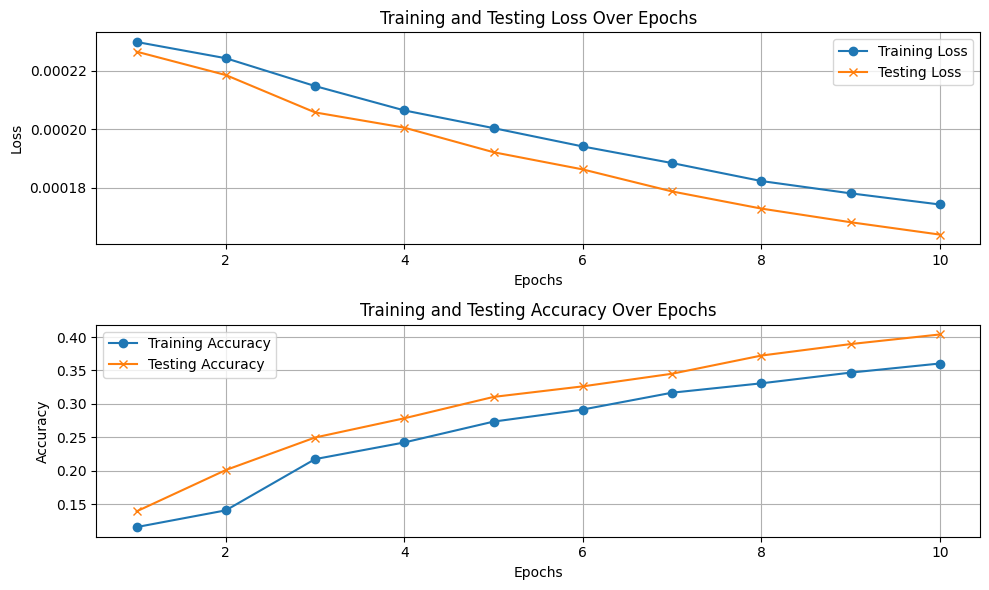

In [13]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            

# 绘制训练和测试损失、精度的折线图
def plot_training_logs(train_loss, test_loss, train_acc, test_acc):
    epochs = range(1, len(train_loss) + 1)
    
    # 创建一个图形，并设置图形的大小
    plt.figure(figsize=(10, 6))
    
    # 绘制训练和测试损失折线
    plt.subplot(211)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, test_loss, label='Testing Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    
    # 绘制训练和测试准确率折线
    plt.subplot(212)
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, test_acc, label='Testing Accuracy', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    
    # 调整子图之间的间距
    plt.tight_layout()
    
    plt.show()

# 使用函数绘制损失和准确率折线图
plot_training_logs(training_loss, testing_loss, training_acc, testing_acc)      

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [14]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [15]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
probabilities = torch.softmax(outputs, dim=1)
predict_label = torch.argmax(probabilities, dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


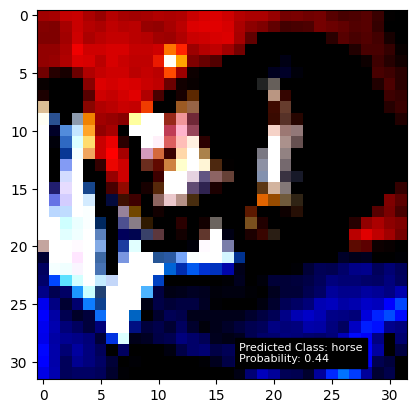

Print probabilities for each class:
airplane: 0.0043
automobile: 0.0111
bird: 0.0673
cat: 0.1418
deer: 0.0774
dog: 0.2205
frog: 0.0271
horse: 0.4389
ship: 0.0084
truck: 0.0032


In [22]:
predicted_class = class_names[predict_label[0].item()]
predicted_probability = probabilities[0][predict_label[0]].item()
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0][i].item():.4f}')